# Studying mobility changes due to covid 19 political measures

#### Using Google mobility dataset from https://www.google.com/covid19/mobility/
input : https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv?cachebust=a88b56a24e1a1e25

output [not shown here]: 
- df as Google_mobility_raw_df
- df_param as Google_mobility_fit_df_param

In [180]:
import math
import numpy as np
import pandas as pd
from random import randint

import matplotlib.pyplot as plt

from scipy import optimize
from scipy.optimize import minimize
from sklearn import decomposition

import requests as re
import json as js

import time
from datetime import datetime
from dateutil.parser import *
import itertools

## import data for mobility from Google

In [2]:
dfm = pd.read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv?cachebust=a88b56a24e1a1e25", low_memory = False)
dfm.head()

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


#### suppress and rename columns

In [3]:
dfm['date'] = pd.to_datetime(dfm['date'])
dfm = dfm[dfm.isna()['sub_region_1']]
dfm = dfm.drop(columns = ['sub_region_1','sub_region_2','country_region_code'])
dfm = dfm.rename(columns = {'country_region' : 'Country',
                            'grocery_and_pharmacy_percent_change_from_baseline' : 'Grocery & pharmacy',
                            'parks_percent_change_from_baseline' : 'Parks',
                            'residential_percent_change_from_baseline' : 'Residential',
                            'retail_and_recreation_percent_change_from_baseline': 'Retail & recreation',
                            'transit_stations_percent_change_from_baseline' : 'Transit stations',
                            'workplaces_percent_change_from_baseline' : 'Workplace'})
dfm.head()

,Country,date,Retail & recreation,Grocery & pharmacy,Parks,Transit stations,Workplace,Residential
0,United Arab Emirates,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,United Arab Emirates,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,United Arab Emirates,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,United Arab Emirates,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,United Arab Emirates,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


#### use date as index and countries as multiindexed columns

In [4]:
df = dfm.pivot_table(index = 'date',columns = ['Country'])
df = df.swaplevel(i=0,j=1,axis=1).sort_index(axis=1)
df = df.rename_axis(('Country','Sector'), axis=1)
df.head()

Country           Afghanistan                                        \
Sector     Grocery & pharmacy Parks Residential Retail & recreation   
date                                                                  
2020-02-15              -10.0   0.0         5.0                -9.0   
2020-02-16               11.0   1.0         0.0                 3.0   
2020-02-17               11.0   2.0        -1.0                 6.0   
2020-02-18                5.0   3.0        -1.0                 3.0   
2020-02-19                3.0   1.0         1.0                -1.0   

Country                                           Angola                    \
Sector     Transit stations Workplace Grocery & pharmacy Parks Residential   
date                                                                         
2020-02-15             -2.0     -28.0               -2.0   7.0         1.0   
2020-02-16             10.0       4.0                0.0 -11.0         2.0   
2020-02-17              9.0       5.0               -4.0   2.0         0.0   
2020-02-18              9.0       6.0               -4.0  -4.0        -1.0   
2020-02-19              0.0       5.0              -12.0  -3.0         1.0   

Country                         ...      Zambia                      \
Sector     Retail & recreation  ... Residential Retail & recreation   
date                            ...                                   
2020-02-15                 3.0  ...         4.0                -1.0   
2020-02-16                -4.0  ...         3.0                -4.0   
2020-02-17                -6.0  ...         3.0                -8.0   
2020-02-18                -3.0  ...         2.0                -6.0   
2020-02-19               -10.0  ...         3.0                -8.0   

Country                                         Zimbabwe                    \
Sector     Transit stations Workplace Grocery & pharmacy Parks Residential   
date                                                                         
2020-02-15             -5.0       7.0                0.0  -1.0         1.0   
2020-02-16             -7.0       2.0               -3.0  -6.0         3.0   
2020-02-17             -8.0       8.0               -2.0  -1.0         1.0   
2020-02-18             -4.0       6.0                4.0   0.0         2.0   
2020-02-19             -7.0       4.0                1.0  -4.0         1.0   

Country                                                    
Sector     Retail & recreation Transit stations Workplace  
date                                                       
2020-02-15                -4.0            -11.0       0.0  
2020-02-16                -8.0            -11.0      -2.0  
2020-02-17                -3.0             -7.0       8.0  
2020-02-18                 1.0             -6.0       7.0  
2020-02-19                -2.0             -8.0       5.0  

[5 rows x 787 columns]

#### check visually whether the dataset shows clear trends: per-sector averages over countries

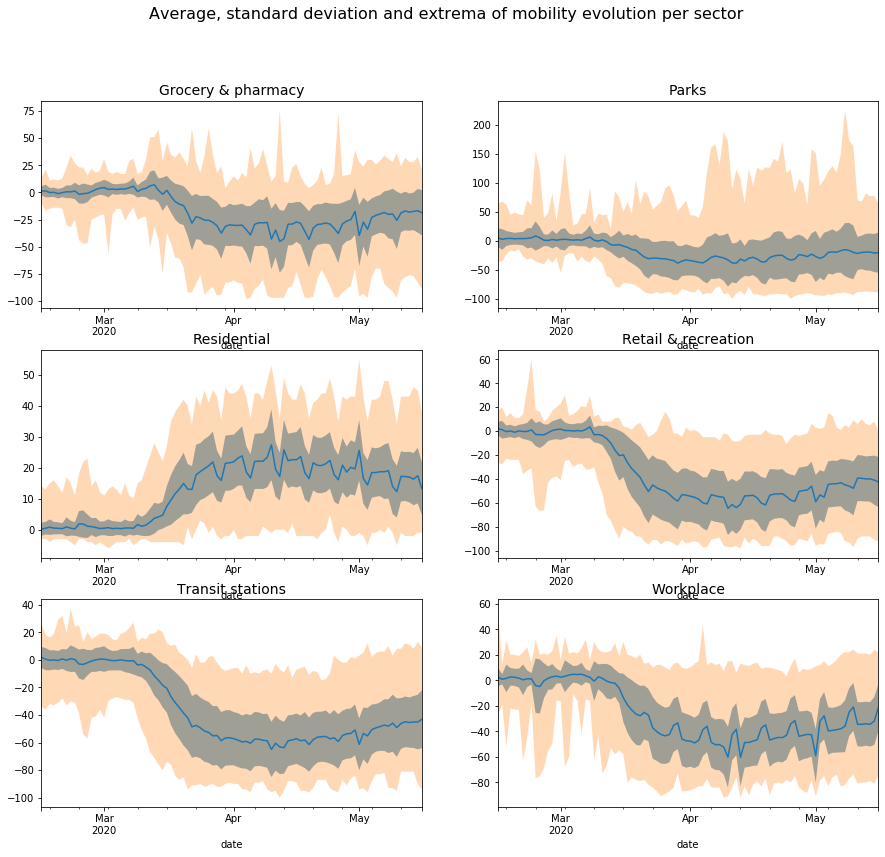

In [5]:
plt.figure(figsize = (15,13)).suptitle('Average, standard deviation and extrema of mobility evolution per sector',size=16)
count = 0
for sector, new_df in df.groupby(level=1, axis=1):
    count += 1
    ax=plt.subplot(3,2,count)
    ax.set_title(sector,size=14)
    avg = new_df.mean(axis=1)
    avg.plot(legend=None)
    dev = np.std(new_df, axis=1)
    plt.fill_between(new_df.index, avg-dev,avg+dev, alpha=0.6)
    plt.fill_between(new_df.index, new_df.min(axis=1),new_df.max(axis=1), alpha=0.3)
plt.show()

#### improve the representation by adding weekends&features

In [6]:
# change sign for residential mobility change
df.loc[:, pd.IndexSlice[:, 'Residential']] *= -1 

# situation slowly goes back to normal from around 15-20th April. Keep only data before
df = df.drop(df.index[df.index > pd.to_datetime('2020-04-20')], axis = 0)

In [7]:
# create functions to highlight weekends
    # 1. find indices of weekend in df.index
def find_weekend_indices(datetime_array):
    indices = []
    for i in range(len(datetime_array)):
        if datetime_array[i].weekday() >= 5:
            indices.append(i)
    return indices

    # 2. highlight weekends in the plot
def highlight_datetimes(indices, ax):
    i = 0
    while i < len(indices)-1:
        ax.axvspan(df.index[indices[i]], df.index[indices[i] + 1], facecolor='green', edgecolor='none', alpha=.05)
        i += 1

In [8]:
df_by_sector = df.groupby(level=1,axis=1).mean()
df_by_sector.loc[:,'All sectors'] = df_by_sector.loc[:,'Grocery & pharmacy':'Workplace'].mean(axis=1)
df_by_sector.head()

Sector,Grocery & pharmacy,Parks,Residential,Retail & recreation,Transit stations,Workplace,All sectors
date,,,,,,,
2020-02-15,1.465649,5.546154,-0.178295,2.128788,1.730769,2.442748,2.189302
2020-02-16,1.404580,2.692308,-0.503937,1.143939,0.476923,0.830769,1.007430
2020-02-17,-0.068702,4.207692,-0.844961,-0.386364,-0.328244,1.492424,0.678641
2020-02-18,0.128788,4.407692,-0.527132,0.128788,-0.068702,2.704545,1.128997
2020-02-19,-1.076336,3.800000,-0.472868,-0.939394,-0.450382,2.325758,0.531130


These graphs show which sectors underwent the largest evolution due to confinement measures.


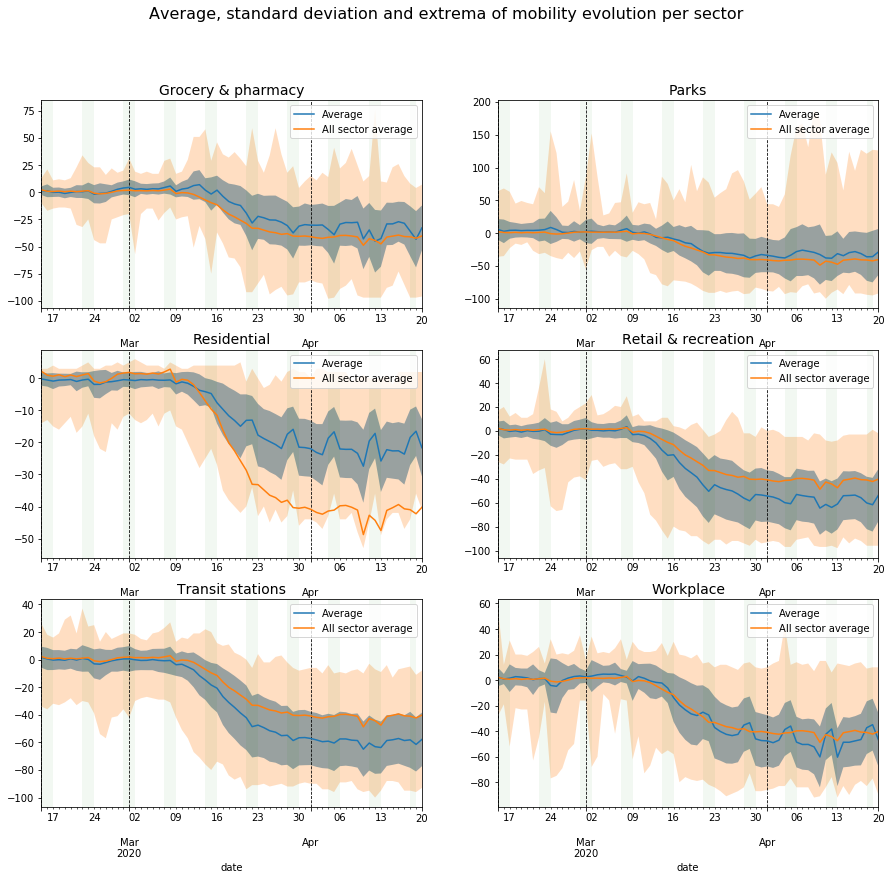

In [9]:
# show temporal evolution for each sector as compared to mean
plt.figure(figsize = (15,13)).suptitle('Average, standard deviation and extrema of mobility evolution per sector',size=16)
count = 0
for sector, new_df in df.groupby(level=1, axis=1):
    count += 1
    ax = plt.subplot(3,2,count)
    ax.set_title(sector,size=14)
    
    # plot averages
    avg = new_df.mean(axis=1)
    avg.plot()
    df_by_sector['All sectors'].plot().legend(['Average','All sector average'])
    
    # display standard deviation and min-max range
    dev = np.std(new_df, axis=1)
    plt.fill_between(new_df.index, avg-dev,avg+dev, alpha=0.6)
    plt.fill_between(new_df.index, new_df.min(axis=1),new_df.max(axis=1), alpha=0.25)
    
    # display weekends and change of month
    weekend_indices = find_weekend_indices(new_df.index)
    highlight_datetimes(weekend_indices, ax)
    ax.xaxis.grid(b=True, which='major', color='black', linestyle='--', alpha=1)

print('These graphs show which sectors underwent the largest evolution due to confinement measures.')   
plt.show()

## fit a sigmoid function

#### define sigmoid function and cost function

In [10]:
def sigmoid(x,l,m,a,b):
    return a / (1 + np.exp( -(x-m)/l ) )+b

def sumsq(p):
    l,m,a,b = p
    error = np.mean( (y - sigmoid(x,l,m,a,b)) **2 )
    #print(l,m,a,b,error)
    return error

### proof-of concept with a single fit

3.3665000174331965 31.90489795397287 -59.527292534199766 0.1859301113815329


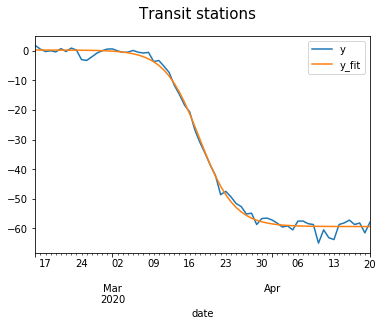

In [139]:
# define independant variable
x = df.index.dayofyear
x = x.astype('float')
x -= min(x)

# define dependant variable (train)
df_fit = pd.DataFrame()
df_fit['y'] = df_by_sector['Transit stations']
y = df_fit['y']

# fit
msol = minimize(sumsq, [0.5,0.001,0.001,0.001], method='L-BFGS-B')
l,m,a,b = msol['x']
df_fit['y_fit'] = sigmoid(x,l,m,a,b)

# visual check
print(l,m,a,b)
df_fit.plot()
plt.suptitle('Transit stations',size= 15)
plt.show()

## Find the 'confinment' day
### Use the sigmoid to find the day of transition for each country, each sector
Strategy 1: fit all the data then take the average of the transition day

#### 1a) Fit the sigmoid function

In [18]:
# creation of an empty dataframe to gather the fitting coefficients
#df_param = pd.DataFrame(columns = df.columns,
#                             index = ['acuteness','transition day','intensity','offset','error'])
#df_param

df_param = df.reset_index()
df_param = df_param.drop(index = df_param.index)
df_param = df_param.drop(columns = 'date',level=0)
df_param['parameters'] = ['transition length','transition day','intensity','offset','error']
df_param = df_param.set_index('parameters')
df_param

Country                  Afghanistan                                        \
Sector            Grocery & pharmacy Parks Residential Retail & recreation   
parameters                                                                   
transition length                NaN   NaN         NaN                 NaN   
transition day                   NaN   NaN         NaN                 NaN   
intensity                        NaN   NaN         NaN                 NaN   
offset                           NaN   NaN         NaN                 NaN   
error                            NaN   NaN         NaN                 NaN   

Country                                                  Angola        \
Sector            Transit stations Workplace Grocery & pharmacy Parks   
parameters                                                              
transition length              NaN       NaN                NaN   NaN   
transition day                 NaN       NaN                NaN   NaN   
intensity                      NaN       NaN                NaN   NaN   
offset                         NaN       NaN                NaN   NaN   
error                          NaN       NaN                NaN   NaN   

Country                                            ...      Zambia  \
Sector            Residential Retail & recreation  ... Residential   
parameters                                         ...               
transition length         NaN                 NaN  ...         NaN   
transition day            NaN                 NaN  ...         NaN   
intensity                 NaN                 NaN  ...         NaN   
offset                    NaN                 NaN  ...         NaN   
error                     NaN                 NaN  ...         NaN   

Country                                                           \
Sector            Retail & recreation Transit stations Workplace   
parameters                                                         
transition length                 NaN              NaN       NaN   
transition day                    NaN              NaN       NaN   
intensity                         NaN              NaN       NaN   
offset                            NaN              NaN       NaN   
error                             NaN              NaN       NaN   

Country                     Zimbabwe                                        \
Sector            Grocery & pharmacy Parks Residential Retail & recreation   
parameters                                                                   
transition length                NaN   NaN         NaN                 NaN   
transition day                   NaN   NaN         NaN                 NaN   
intensity                        NaN   NaN         NaN                 NaN   
offset                           NaN   NaN         NaN                 NaN   
error                            NaN   NaN         NaN                 NaN   

Country                                       
Sector            Transit stations Workplace  
parameters                                    
transition length              NaN       NaN  
transition day                 NaN       NaN  
intensity                      NaN       NaN  
offset                         NaN       NaN  
error                          NaN       NaN  

[5 rows x 787 columns]

In [19]:
#finding column names
sectors = list(df_param.groupby('Sector',axis=1).min().columns.get_level_values('Sector'))
countries = list(df_param.groupby('Country',axis=1).min().columns.get_level_values('Country'))
sectors

['Grocery & pharmacy',
 'Parks',
 'Residential',
 'Retail & recreation',
 'Transit stations',
 'Workplace']

In [69]:
# fit the sigmoid accross the entire data set
region = []
count_short = 0
count_long = 0
time_short = 0
time_long = 0
count = 0
START = time.time()

for i in df_param:

    if region != i[0]:
        region = i[0]
        count += 1
#        if count == 2:
#            break
        print(count, region)
        
    y = df.loc[:,i]  
    up = max(abs(y)) # largest plausible interval

    if y.isnull().values.any(): 
        start = time.time()
        
        # if there are NaN values in a, use a robust method (almost 2x slower)
        msol = minimize(sumsq,
                    [0.1,0.001,0.001,0.001],
                    method='L-BFGS-B',
                    bounds=[(0.1,10),(min(x),max(x)),(-up,up),(-up,up)])
        
        (l,m,a,b) = msol['x']
        df_param.loc['transition length',i] = l
        df_param.loc['transition day',i] = m
        df_param.loc['intensity',i] = a
        df_param.loc['offset',i] = b
        df_param.loc['error',i] = msol['fun'] 
        
        # time performance
        end = time.time()
        count_short += 1
        time_short += end - start
        
    else:
        start = time.time()
        
        # if there is no NaN values in a, use the fast method
        (l,m,a,b), _ = optimize.curve_fit(sigmoid, x, y, bounds=([0.1, 0., -up, -up, ], [10., 50., up, up, ]))
        df_param.loc['transition length',i] = l
        df_param.loc['transition day',i] = m
        df_param.loc['intensity',i] = a
        df_param.loc['offset',i] = b
        df_param.loc['error',i] = np.sum( (sigmoid(x,l,m,a,b) - y)**2 )
    
        # time performance       
        end = time.time()
        count_long += 1
        time_long += end - start    

END =time.time() 

try: 
    time_short = time_short / count_short
except: 
    time_sort = None
    
try: 
    time_long = time_long / count_long
except: 
    time_long = None
    
print('\n', time_short, time_long)
print('total time: ', END-START)

1 Afghanistan
2 Angola
3 Antigua and Barbuda
4 Argentina
5 Aruba
6 Australia
7 Austria
8 Bahrain
9 Bangladesh
10 Barbados
11 Belarus
12 Belgium
13 Belize
14 Benin
15 Bolivia
16 Bosnia and Herzegovina
17 Botswana
18 Brazil
19 Bulgaria
20 Burkina Faso
21 Cambodia
22 Cameroon
23 Canada
24 Cape Verde
25 Chile
26 Colombia
27 Costa Rica
28 Croatia
29 Czechia
30 Côte d'Ivoire
31 Denmark
32 Dominican Republic
33 Ecuador
34 Egypt
35 El Salvador
36 Estonia
37 Fiji
38 Finland
39 France
40 Gabon
41 Georgia
42 Germany
43 Ghana
44 Greece
45 Guatemala
46 Guinea-Bissau
47 Haiti
48 Honduras
49 Hong Kong
50 Hungary
51 India
52 Indonesia
53 Iraq
54 Ireland
55 Israel
56 Italy
57 Jamaica
58 Japan
59 Jordan
60 Kazakhstan
61 Kenya
62 Kuwait
63 Kyrgyzstan
64 Laos
65 Latvia
66 Lebanon
67 Libya
68 Liechtenstein
69 Lithuania
70 Luxembourg
71 Malaysia
72 Mali
73 Malta
74 Mauritius
75 Mexico
76 Moldova
77 Mongolia
78 Mozambique
79 Myanmar (Burma)
80 Namibia
81 Nepal
82 Netherlands
83 New Zealand
84 Nicaragua
85 Ni

4.023403492305589 30.652346966349477 -58.17015166663144 7.152006428100073


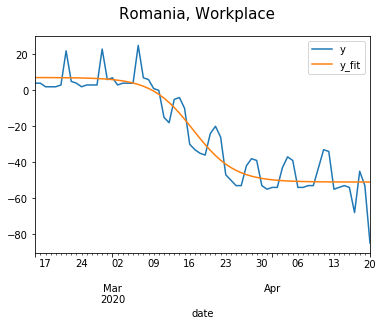

In [72]:
# check visually that the fit has worked.
# select random column
from random import randint
i =  randint(0,len(df_param.columns))
column = df_param.columns[i]

# gather the data
l,m,a,b = df_param.loc[['transition length','transition day','intensity','offset'],column]
df_fit['y'] = df[column]
df_fit['y_fit'] = sigmoid(x,l,m,a,b)

# plot
print(l,m,a,b)
df_fit.plot()
plt.suptitle(column[0]+ ', ' + column[1],size= 15)
plt.show()

#### 1b) Take averages from the fitted parameters

In [73]:
df_param_means = df_param.groupby('Country', axis = 1).mean()

### 2 Fit the sigmoid on per-sector time series averages
#### 2a) Normalising the data (time series) before averaging
Otherwise, the intensity of change would act as a weigh and make some sectors more important than others (sectors with largest evolution). This is not desired since information about reliability and statistical significance of the dataset per sector are not available. Moreover we are interested in a proxy for the confinment day, so we want transition day to be the most accurate possible, not intensity

The price to pay is that all information about intensity will be lost, as curves will be squeezed into decreasing sigmoids from +1 to -1

Still, from a busines POV, this method is expected to yield bad results since the higher the variation, the clearer the transition

In [74]:
# normalise the data
df_normalised = (df-df.mean())/df.std()

# calculate unweighed average (remember that I took the opposite sign for Residentials)
df_means_norm = df_normalised.groupby('Country', axis = 1).mean()

# creation of an empty dataframe to gather the fitting coefficients
df_means_norm_param = pd.DataFrame(columns = df_means_norm.columns,
                             index = ['transition length','transition day','intensity','offset','error'])

# fit the sigmoid on df_means
for i in df_means_norm_param:
        
    y = df_means_norm.loc[:,i]  
    up = max(abs(y)) # largest plausible interval
    msol = minimize(sumsq,
                    [0.1,0.001,0.001,0.001],
                    method='L-BFGS-B',
                    bounds=[(0.1,10),(min(x),max(x)),(-up,up),(-up,up)])

    df_means_norm_param.loc['transition length',i],df_means_norm_param.loc['transition day',i],df_means_norm_param.loc['intensity',i],df_means_norm_param.loc['offset',i] = msol['x']
    df_means_norm_param.loc['error',i] = msol['fun']

These graphs show which sectors underwent the largest evolution due to confinement measures.


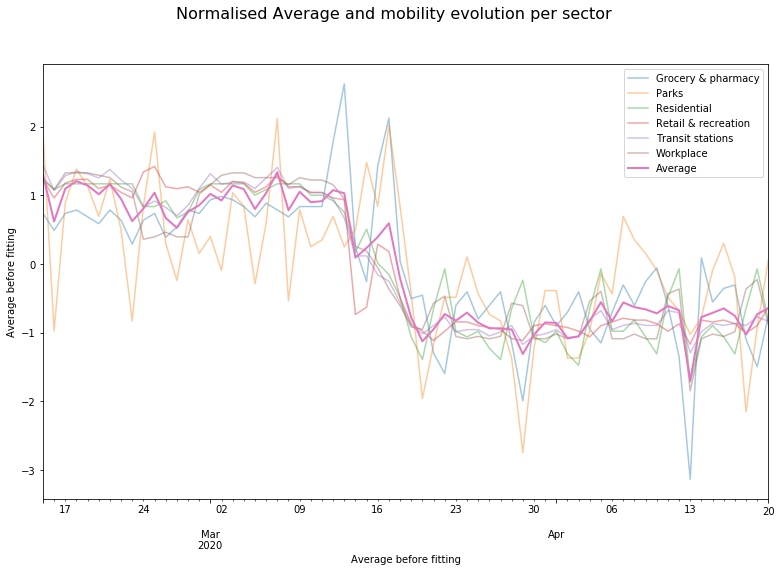

In [75]:
# show temporal evolution for each sector for normalised data
plt.figure(figsize = (13,8)).suptitle('Normalised Average and mobility evolution per sector',size=16)

ax.set_title(sector,size=14)

country = 'Belgium'

for sector in df_normalised[country]:
    df_normalised[country,sector].plot(alpha = 0.4)

# plot averages
avg = df_normalised[country].mean(axis=1)
labels = list(np.copy(sectors))
labels.append('Average')
avg.plot(linewidth=2.0).legend(labels)  
plt.xlabel('Average before fitting')
plt.ylabel('Average before fitting')

print('These graphs show which sectors underwent the largest evolution due to confinement measures.')   
plt.show()

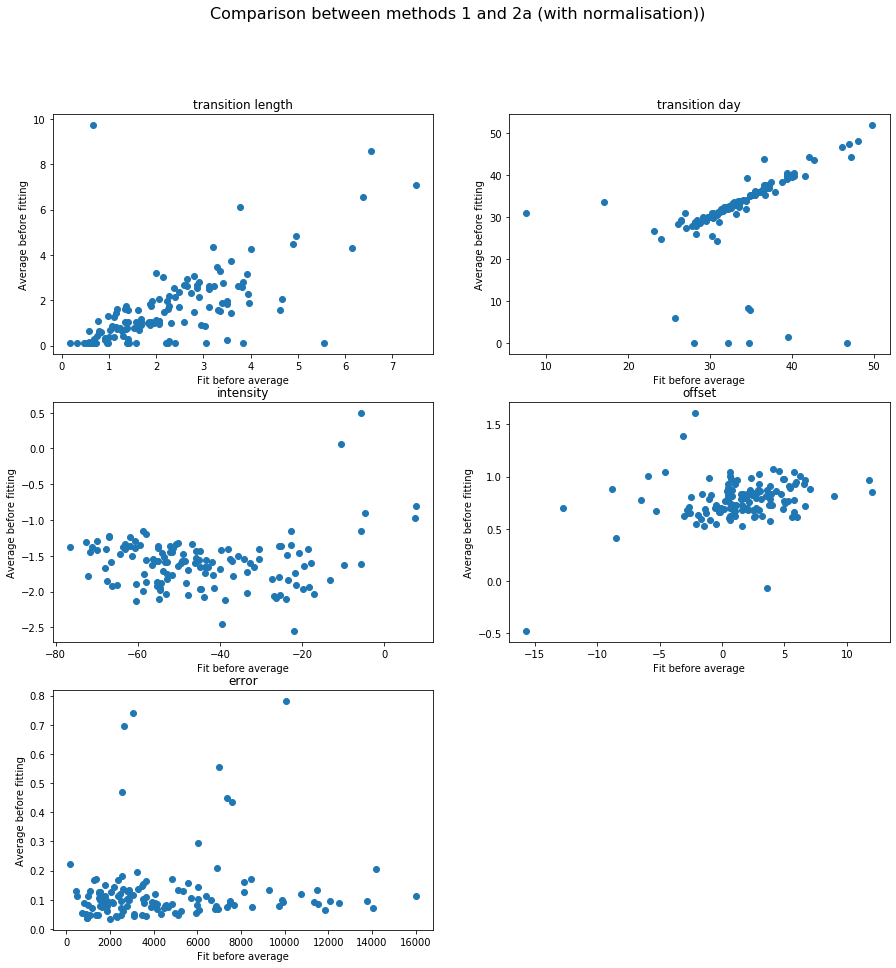

In [76]:
# visualisation of the results
plt.figure(figsize = (15,15)).suptitle('Comparison between methods 1 and 2a (with normalisation))',size=16)

count = 0
for row in df_means_norm_param.index:
    count += 1
    
    ax=plt.subplot(3,2,count)
    transition_day = np.array([np.array(df_param_means.loc[row]), 
                  np.array(df_means_norm_param.loc[row])])
    plt.plot(transition_day[0], transition_day[1], 'o')
    plt.xlabel('Fit before average')
    plt.ylabel('Average before fitting')
    plt.title(row)
    
plt.show()

The above graphs show the difference in the parameters of the sigmoids when:
- we fit each sector separately then average the transition day to find the confinment;
- we normalise the % of change, average the trends, then only fit the resulting time series per country.
Few to no relationship is found. This indicates that:
- it is crucial to choose appropriately the method / one method might yield much better predictions than the other;
- the transition day parameter is the least sensible, though it represents the day at the half of the transition (whereas the day at which policies are taken should be at the beginning : also depends on 1/acuteness)
- intensities not related at all: the information seems lost. 
A graph will compare the corresponding sigmoids hereunder

#### 2b) Without normalising the data (time series) before averaging

In [77]:
# calculate unweighed average (remember that I took the opposite sign for Residentials)
df_means = df.groupby('Country', axis = 1).mean()

# creation of an empty dataframe to gather the fitting coefficients
df_means_param = pd.DataFrame(columns = df_means.columns,
                             index = ['transition length','transition day','intensity','offset','error'])

# fit the sigmoid on df_means
for i in df_means_param:
        
    y = df_means.loc[:,i]  
    up = max(abs(y)) # largest plausible interval
    msol = minimize(sumsq,
                    [0.1,0.001,0.001,0.001],
                    method='L-BFGS-B',
                    bounds=[(0.1,10),(min(x),max(x)),(-up,up),(-up,up)])

    df_means_param.loc['transition length',i],df_means_param.loc['transition day',i],df_means_param.loc['intensity',i],df_means_param.loc['offset',i] = msol['x']
    df_means_param.loc['error',i] = msol['fun']

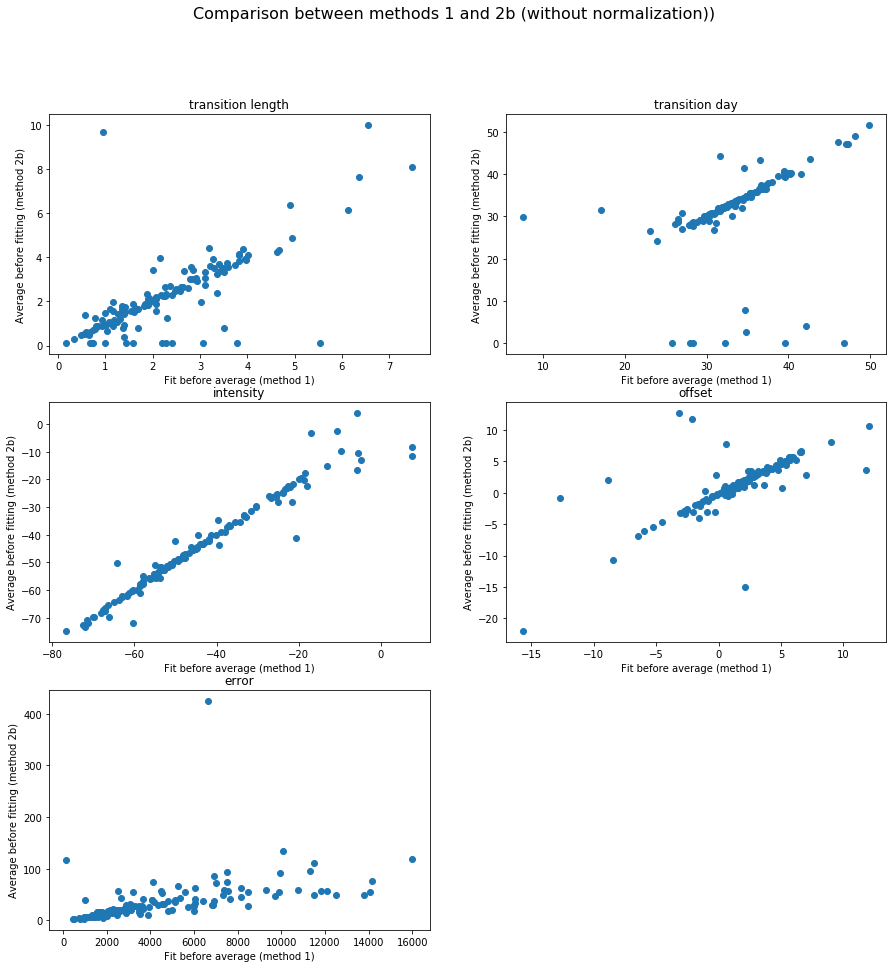

In [78]:
# visualisation
plt.figure(figsize = (15,15)).suptitle('Comparison between methods 1 and 2b (without normalization))',size=16)

count = 0
for row in df_means_param.index:
    count += 1
    
    ax=plt.subplot(3,2,count)
    transition_day = np.array([np.array(df_param_means.loc[row]), 
                  np.array(df_means_param.loc[row])])
    plt.plot(transition_day[0], transition_day[1], 'o')
    plt.xlabel('Fit before average (method 1)')
    plt.ylabel('Average before fitting (method 2b)')
    plt.title(row)
   
plt.show()

The above graphs show the difference in the parameters of the sigmoids when:
- we fit each sector separately then average the transition day to find the confinment;
- we do not normalise the % of change, we do average the trends, then only fit the resulting time series per country.
Few to no relationship is found. This indicates that:
- much better correlations than when normalising. The
- the information on intensity is much more consistent 
- in general, the better agreement DOES NOT MEAN that the method is better, only that it looks more like method 1. The best method will be the one who fits the best with the confinment measures/transmission rates (see later)

This method seems good because it allows for an enormous reduction in the error - quality of the fit augmented by far. 

In [128]:
#Let me check which country reaches an error of 16000 in method 1:
print(df_param_means.loc['error'].astype(float).idxmax()) # Denmark
# which country has an error of 400 in method 2b? 
print(df_means_param.loc['error'].astype(float).idxmax()) # Jordan
# which country has an error in method (1,2b) = (0,115) ?
print(df_param_means.loc['error'].astype(float).idxmin(), df_means_param.loc['error','Liechtenstein'])

Denmark
Jordan
Liechtenstein 116.20019729101908


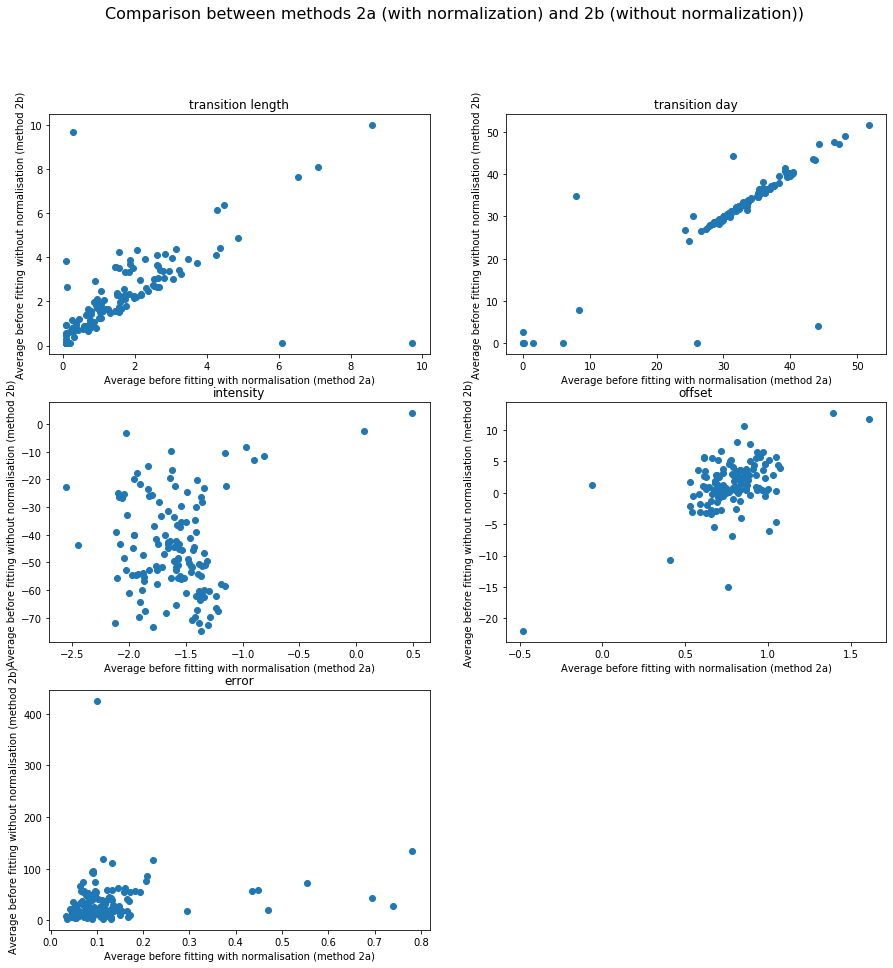

In [80]:
plt.figure(figsize = (15,15)).suptitle('Comparison between methods 2a (with normalization) and 2b (without normalization))',size=16)

count = 0
for row in df_means_param.index:
    count += 1
    
    ax=plt.subplot(3,2,count)
    transition_day = np.array([np.array(df_means_norm_param.loc[row]), 
                  np.array(df_means_param.loc[row])])
    plt.plot(transition_day[0], transition_day[1], 'o')
    plt.xlabel('Average before fitting with normalisation (method 2a)')
    plt.ylabel('Average before fitting without normalisation (method 2b)')
    plt.title(row)
   
plt.show()

#### Visulising the differences for some choosen countries.
- Kyrgyzstan displays large weekend effect
- Antigua and Barbuda "argues" that the most robust method is the fit over averaged data, without normalisation
- Japan shows only the fit before average captures appropriately the transition
- Jordan has an error in average before fit without normalisation (fit over non normalised average just doesn't work...)
- Denmark has the largest error in fit before average (people doubled park frequentation)
- Mongolia shows no trend (and the three methods disagree on transition lenghts, transition day and sign of change !) 

what is interesting to see here is really the shape of the transitions, not the vertical position


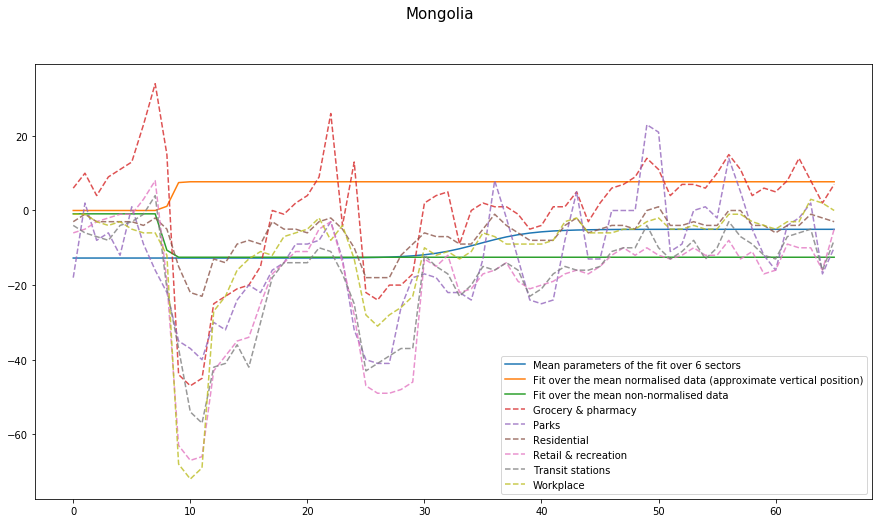

In [196]:
# compare the models
# select random country
country = countries[randint(0,len(countries))] # Mozambique, Gana... show that mean(acuteness) is not correctly implemented

# gather the data
df_fit = pd.DataFrame()
l,m,a,b = df_param_means.loc[['transition length','transition day','intensity','offset'],country]
df_fit['y_fit_1'] = sigmoid(x,l,m,a,b)

l,m,a,b = df_means_norm_param.loc[['transition length','transition day','intensity','offset'],country]
df_fit['y_fit_2a'] = sigmoid(x,l,m,a,b)

l,m,a,b = df_means_param.loc[['transition length','transition day','intensity','offset'],country]
df_fit['y_fit_2b'] = sigmoid(x,l,m,a,b)

# scale correction for the pre-normalised data
scale = df_param_means.loc['intensity',country] / df_means_norm_param.loc['intensity',country]
df_fit['y_fit_2a'] -= df_fit['y_fit_2a'][0]
df_fit['y_fit_2a'] *= scale
df_fit['y_fit_2a'] += scale*df_fit['y_fit_2a'][0]

# plot
labels = ['Mean parameters of the fit over 6 sectors','Fit over the mean normalised data (approximate vertical position)','Fit over the mean non-normalised data','Method 1, corrected acuteness']
plt.figure(figsize = (15,8)).suptitle('Comparison between methods and data',size=16)
plt.plot(x, df_fit['y_fit_1'], label = labels[0])
plt.plot(x, df_fit['y_fit_2a'], label = labels[1])
plt.plot(x, df_fit['y_fit_2b'], label = labels[2])
for sector in df.xs(country, axis = 1, level = 0):
    plt.plot(x,df.xs(country, axis = 1, level = 0)[sector], alpha =0.8, label = sector, linestyle = '--')
    
plt.suptitle(country,size= 15)
plt.legend()
print('what is interesting to see here is really the shape of the transitions, not the vertical position')
plt.show()


tbh, the most worrying countries (the countries for which the transition day estimate is the least reliable) are obviously those for which transition length or/and transition day strongly disagrees between methods. Let me explore a last method before coming back to this.

#### 3) Fitting the sigmoid on the first principal component of the time series
First component should take up the global evolution; second component the week-ends; then nothing obvious.
Note that Residential behaves the other way round as compared to the 5 other components. 

number of componants: 4
explained variance per component: [76.01804672 15.66498127  4.82826283  3.20837658]
total explained variance: 0.9971966740777032


Text(0.5, 1.0, 'Cumulative proportion of variance explained')

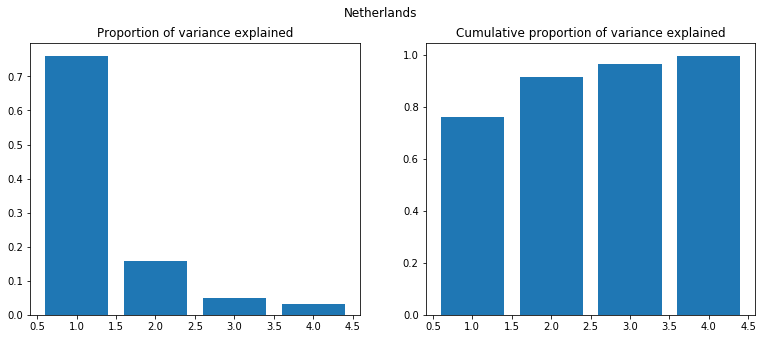

In [200]:
country = countries[randint(0,len(countries))] # Mozambique, Gana... show that mean(acuteness) is not correctly implemented

X = df.xs(country, axis = 1, level = 0)

# Apply PCA
pca = decomposition.PCA(0.99)
pca.fit(X)
Xpca = pca.transform(X)
print('number of componants: ' + str(pca.n_components_))
print('explained variance per component: ' + str(pca.explained_variance_ratio_*100))
print('total explained variance: ' + str(sum(pca.explained_variance_ratio_)))

# visualisation: %variance per Principal Component
plt.figure(figsize = (13,5)).suptitle(country)
plt.subplot(1,2, 1)
plt.bar(range(1,pca.n_components_+1),pca.explained_variance_ratio_)
plt.title('Proportion of variance explained')

# visualisation: cumulative % variance per Principal Component
plt.subplot(1,2, 2)
data = []
for i in range(1,pca.n_components_+1):
    data.append(sum(pca.explained_variance_ratio_[0:i]))
plt.bar(range(1,pca.n_components_+1),data)
plt.title('Cumulative proportion of variance explained')

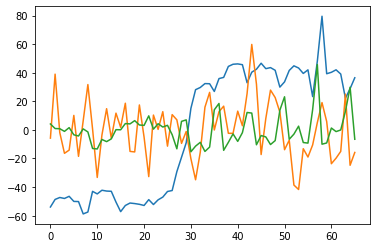

In [201]:
plt.plot(Xpca[:,0:3])

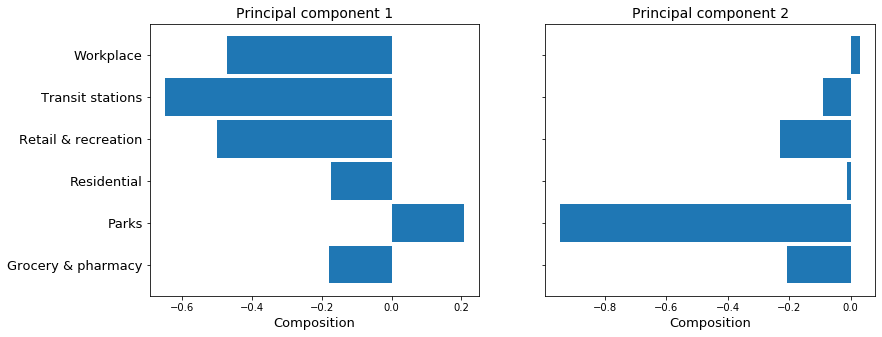

In [204]:
# Composition of PC1 and PC2, grouped by sigmoid parameters
labels = list(df.xs(country, axis = 1, level = 0).columns)

fig, ax = plt.subplots(1, 2,figsize = (13,5),sharey = True)

numel = pca.components_.shape[1]
xpos = np.arange(numel)  # the label locations
width = 0.9  # the width of the bars  

for j in [0,1]:
    
    pc_compo = []
#    for i in range(len(sectors)):
#        pc_compo.append((pca.components_[j])[np.array(range(i,pca.n_features_,len(sectors)))[:]])
#        ax[j].barh(x - 2*width-width/2+i/len(labels), pc_compo[i], width, label=sectors[i])
        
    pc_compo =pca.components_[j]
    ax[j].barh(xpos, pc_compo, width)  

    ax[j].set_xlabel('Composition',size=13)
    ax[j].set_title('Principal component ' + str(j+1),size=14)
    ax[j].set_yticks(xpos)
    ax[j].set_yticklabels(labels,size=13)

   # if j == 1:
   #     ax[j].legend(fontsize = 12,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [211]:
# creation of empty dataframes to gather the pc1 and fitting coefficients
df_pca = pd.DataFrame(columns = countries, index = x)

df_pca_param = pd.DataFrame(columns = df_means.columns,
                             index = ['transition length','transition day','intensity','offset','error'])
    
for country in countries:
    X = df.xs(country, axis = 1, level = 0)

    # Apply PCA
    pca = decomposition.PCA(1) # cette ligne peut sortir de la boucle nan ?
    pca.fit(X)
    Xpca = pca.transform(X)
    
    df_pca[country] = Xpca.T[0]
    
for country in countries: 
    y = df_pca.loc[:,country]  
    up = max(abs(y)) # largest plausible interval
    msol = minimize(sumsq,
                    [0.1,0.001,0.001,0.001],
                    method='L-BFGS-B',
                    bounds=[(0.1,10),(min(x),max(x)),(-up,up),(-up,up)])

    df_pca_param.loc['transition length',i],df_means_param.loc['transition day',i],df_means_param.loc['intensity',i],df_means_param.loc['offset',i] = msol['x']
    df_pca_param.loc['error',i] = msol['fun']   
    
     

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# TOOOOO BE CONTINUED


calculate unweighed average (remember that I took the opposite sign for Residentials)
df_pca = df.groupby('Country', axis = 1).mean()

# creation of an empty dataframe to gather the fitting coefficients
df_means_param = pd.DataFrame(columns = df_means.columns,
                             index = ['transition length','transition day','intensity','offset','error'])

# fit the sigmoid on df_means
for i in df_means_param:
        
    y = df_means.loc[:,i]  
    up = max(abs(y)) # largest plausible interval
    msol = minimize(sumsq,
                    [0.1,0.001,0.001,0.001],
                    method='L-BFGS-B',
                    bounds=[(0.1,10),(min(x),max(x)),(-up,up),(-up,up)])

    df_means_param.loc['transition length',i],df_means_param.loc['transition day',i],df_means_param.loc['intensity',i],df_means_param.loc['offset',i] = msol['x']
    df_means_param.loc['error',i] = msol['fun']

In [ ]:
# compare the models
# select random country
country = countries[randint(0,len(countries))] # Mozambique, Gana... show that mean(acuteness) is not correctly implemented

# gather the data
df_fit = pd.DataFrame()
l,m,a,b = df_param_means.loc[['transition length','transition day','intensity','offset'],country]
df_fit['y_fit_1'] = sigmoid(x,l,m,a,b)

l,m,a,b = df_means_norm_param.loc[['transition length','transition day','intensity','offset'],country]
df_fit['y_fit_2a'] = sigmoid(x,l,m,a,b)

l,m,a,b = df_means_param.loc[['transition length','transition day','intensity','offset'],country]
df_fit['y_fit_2b'] = sigmoid(x,l,m,a,b)

l,m,a,b = df_pca_param.loc[['transition length','transition day','intensity','offset'],country]
df_fit['y_fit_2b'] = sigmoid(x,l,m,a,b)

# scale correction for the pre-normalised data
scale = df_param_means.loc['intensity',country] / df_means_norm_param.loc['intensity',country]
df_fit['y_fit_2a'] -= df_fit['y_fit_2a'][0]
df_fit['y_fit_2a'] *= scale
df_fit['y_fit_2a'] += scale*df_fit['y_fit_2a'][0]

# plot
labels = ['Mean parameters of the fit over 6 sectors','Fit over the mean normalised data (approximate vertical position)','Fit over the mean non-normalised data','Method 1, corrected acuteness']
plt.figure(figsize = (15,8)).suptitle('Comparison between methods and data',size=16)
plt.plot(x, df_fit['y_fit_1'], label = labels[0])
plt.plot(x, df_fit['y_fit_2a'], label = labels[1])
plt.plot(x, df_fit['y_fit_2b'], label = labels[2])
for sector in df.xs(country, axis = 1, level = 0):
    plt.plot(x,df.xs(country, axis = 1, level = 0)[sector], alpha =0.8, label = sector, linestyle = '--')
    
plt.suptitle(country,size= 15)
plt.legend()
print('what is interesting to see here is really the shape of the transitions, not the vertical position')
plt.show()


## Dealing with NaN values in the original dataset

###### *another idea to which I'll come back sometime*
Here I would like to interpolate for the missing values (see below an example). This assumes:
- for simple holes : dividing the data for concerned country-sector into 3 parts : before transition, after transition, during transition; perform spectral analysis to find the weekly pattern
- for periodic holes (e.g. missing data each weekends) : finding a group of countries sharing similar characteristics (same continent? similar sigmoid parameters - except offset? ...) and extrapolate to the country of interest

In [ ]:
# example of missing values
df['Réunion']
l,m,a,b = df_param.loc[['transition length','transition day','intensity','offset'],column]

In [ ]:
column = tuple(['Réunion','Grocery & pharmacy'])
l,m,a,b = df_param.loc[['transition length','transition day','intensity','offset'],column]
df_fit['y'] = df[column]
df_fit['y_fit'] = sigmoid(x,l,m,a,b)

df_fit.plot()
plt.suptitle(column[0]+ ', ' + column[1],size= 15)
plt.show()